# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load Data

In [2]:
# Load Received Payment Data
received_payment_data = pd.read_csv('Received_Payments_Data.csv', encoding='windows-1252')
received_payment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93937 entries, 0 to 93936
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RECEIPT_METHOD         93937 non-null  object 
 1   CUSTOMER_NAME          93937 non-null  object 
 2   CUSTOMER_NUMBER        93937 non-null  int64  
 3   RECEIPT_DOC_NO         93908 non-null  float64
 4   RECEIPT_DATE           93937 non-null  object 
 5   CLASS                  93937 non-null  object 
 6   CURRENCY_CODE          93937 non-null  object 
 7   Local Amount           93937 non-null  float64
 8   USD Amount             93937 non-null  float64
 9   INVOICE_ALLOCATED      93937 non-null  object 
 10  INVOICE_CREATION_DATE  93937 non-null  object 
 11  DUE_DATE               93937 non-null  object 
 12  PAYMENT_TERM           93937 non-null  object 
 13  INVOICE_CLASS          93937 non-null  object 
 14  INVOICE_CURRENCY_CODE  93937 non-null  object 
 15  IN

In [3]:
# Load Open Invoices Data
open_invoices_data = pd.read_csv('Open_Invoice_data.csv', encoding='windows-1252')
open_invoices_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88204 entries, 0 to 88203
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AS_OF_DATE            88204 non-null  object 
 1   Customer Type         88204 non-null  object 
 2   Customer_Name         88204 non-null  object 
 3   Customer Account No   88201 non-null  float64
 4   Transaction Number    88195 non-null  object 
 5   Transaction Date      88204 non-null  object 
 6   Payment Term          88204 non-null  object 
 7   Due Date              88204 non-null  object 
 8   Transaction Currency  88204 non-null  object 
 9   Local Amount          88204 non-null  object 
 10  Transaction Class     88204 non-null  object 
 11  AGE                   88204 non-null  int64  
 12  USD Amount            88204 non-null  object 
 13  INV_CREATION_DATE     88204 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 9.4+ MB


# Data Preparation

In [4]:
# Ignore observations where invoice value is less than 0
received_payment_data = received_payment_data[received_payment_data['USD Amount'] >= 0]

# Convert date columns to datetime format
received_payment_data['RECEIPT_DATE'] = pd.to_datetime(received_payment_data['RECEIPT_DATE'])
received_payment_data['DUE_DATE'] = pd.to_datetime(received_payment_data['DUE_DATE'])
received_payment_data['INVOICE_CREATION_DATE'] = pd.to_datetime(received_payment_data['INVOICE_CREATION_DATE'])
received_payment_data.head()

/var/folders/67/4t6dp9k533z60p8b01gt6cdc0000gn/T/ipykernel_2412/4225549703.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  received_payment_data['RECEIPT_DATE'] = pd.to_datetime(received_payment_data['RECEIPT_DATE'])
/var/folders/67/4t6dp9k533z60p8b01gt6cdc0000gn/T/ipykernel_2412/4225549703.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  received_payment_data['DUE_DATE'] = pd.to_datetime(received_payment_data['DUE_DATE'])
/var/folders/67/4t6dp9k533z60p8b01gt6cdc0000gn/T/ipykernel_2412/4225549703.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  received_payment_da

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,37403,1.421000e+10,2021-04-20,PMT,USD,370990.92,101018.63040,14200000001,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,183750.00,48990.21133,99200000043,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99210000003,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,1409,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000038,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000039,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods


In [5]:
# Function to parse and standardize datetime format
def parse_datetime(datetime_str):
    try:
        date_part, time_part = datetime_str.split(' ')
        day, month, year = map(int, date_part.split('/'))
        hour, minute = map(int, time_part.split(':'))
        if len(str(year)) == 2:
            year += 2000
            
        standardized_datetime_str = f'{day:02d}/{month:02d}/{year} {hour:02d}:{minute:02d}'
        return standardized_datetime_str
    except Exception as e:
        return pd.NaT  

In [6]:
open_invoices_data['Transaction Date'] = pd.to_datetime(open_invoices_data['Transaction Date'])
open_invoices_data['Due Date'] = pd.to_datetime(open_invoices_data['Due Date'])
open_invoices_data['USD Amount'] = open_invoices_data['USD Amount'].str.replace(",", "")

open_invoices_data['INV_CREATION_DATE'] = open_invoices_data['INV_CREATION_DATE'].apply(parse_datetime)
open_invoices_data['INV_CREATION_DATE'] = pd.to_datetime(open_invoices_data['INV_CREATION_DATE'])
open_invoices_data.head()

/var/folders/67/4t6dp9k533z60p8b01gt6cdc0000gn/T/ipykernel_2412/4143777555.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  open_invoices_data['Transaction Date'] = pd.to_datetime(open_invoices_data['Transaction Date'])
/var/folders/67/4t6dp9k533z60p8b01gt6cdc0000gn/T/ipykernel_2412/4143777555.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  open_invoices_data['Due Date'] = pd.to_datetime(open_invoices_data['Due Date'])


,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
0,04/04/22 1:07,3rd Party,GIVE Corp,49144.0,1.0021E+11,2021-12-21,Immediate,2021-12-21,AED,"-3,088",CREDIT NOTE,105,-3088,2021-12-21 12:53:00
1,04/04/22 1:07,Related Party,AL J Corp,23152.0,1.0022E+11,2022-01-02,30 Days from Inv Date,2022-03-03,USD,"2,000",INVOICE,33,2000,2022-02-01 14:09:00
2,04/04/22 1:07,Related Party,AL J Corp,23152.0,1.0022E+11,2022-03-24,30 Days from Inv Date,2022-04-23,USD,"2,000",INVOICE,-18,2000,2022-03-24 17:46:00
3,04/04/22 1:07,Related Party,AL R Corp,23312.0,1.0022E+11,2022-04-01,15 Days from Inv Date,2022-01-19,AED,"2,415",INVOICE,76,2415,2022-01-05 11:49:00
4,04/04/22 1:07,Related Party,ALLI Corp,7530.0,1.0022E+11,2022-03-03,30 Days from EOM,2022-04-30,AED,"3,800",INVOICE,-25,3800,2022-03-03 22:30:00


In [7]:
# Derive target variable for Received Payment Data
received_payment_data['Late_Payment'] = np.where(received_payment_data['RECEIPT_DATE'] > received_payment_data['DUE_DATE'], 1, 0)

# Feature Engineering

In [8]:
# Derive Payment Terms feature
received_payment_data['PAYMENT_TERM_Days'] = (received_payment_data['DUE_DATE'] - received_payment_data['INVOICE_CREATION_DATE']).dt.days
open_invoices_data['Payment Term_Days'] = (open_invoices_data['Due Date'] - open_invoices_data['INV_CREATION_DATE']).dt.days

### Calculate average and standard deviation of payment time for each customer - Received Payment Data

In [9]:
customer_payment_stats = received_payment_data.groupby('CUSTOMER_NAME').agg({'PAYMENT_TERM_Days': ['mean', 'std']})
customer_payment_stats.columns = ['avg_payment_time', 'std_payment_time']
customer_payment_stats['avg_payment_time'] = customer_payment_stats['avg_payment_time'].fillna(0)
customer_payment_stats['std_payment_time'] = customer_payment_stats['std_payment_time'].fillna(0)
customer_payment_stats.head()

,avg_payment_time,std_payment_time
CUSTOMER_NAME,,
3D D Corp,32.372093,15.387431
6TH Corp,78.444444,7.264832
A3 D Corp,26.600000,2.190890
ABC Corp,90.000000,0.000000
ABDU Corp,70.941406,30.821187


In [10]:
# Perform clustering on customer segments
kmeans = KMeans(n_clusters=3, random_state=42)
customer_payment_stats['segment'] = kmeans.fit_predict(customer_payment_stats)
customer_payment_stats

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,avg_payment_time,std_payment_time,segment
CUSTOMER_NAME,,,
3D D Corp,32.372093,15.387431,2
6TH Corp,78.444444,7.264832,0
A3 D Corp,26.600000,2.190890,2
ABC Corp,90.000000,0.000000,0
ABDU Corp,70.941406,30.821187,0
...,...,...,...
YOUS Corp,75.000000,35.032452,0
ZAHR Corp,95.785714,17.703448,0
ZAIN Corp,32.119048,17.081158,2


In [11]:
#Adding the features in the training data
customer_payment_stats = customer_payment_stats.reset_index(drop=False)
received_payment_data = pd.merge(received_payment_data, customer_payment_stats, on='CUSTOMER_NAME', how='left')
received_payment_data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,...,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,Late_Payment,PAYMENT_TERM_Days,avg_payment_time,std_payment_time,segment
0,WIRE,C EA Corp,37403,1.421000e+10,2021-04-20,PMT,USD,370990.92,101018.63040,14200000001,...,2020-12-30,30 Days from EOM,INV,AED,Non Goods,1,58,47.000000,14.933185,0
1,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,183750.00,48990.21133,99200000043,...,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods,1,30,36.550091,22.280298,2
2,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99210000003,...,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,0,30,36.550091,22.280298,2
3,WIRE,FARO Corp,1409,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000038,...,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,1,30,42.939749,22.303248,2
4,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000039,...,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,1,30,36.550091,22.280298,2


### Calculate average and standard deviation of payment time for each customer - Open Invoice Data

In [12]:
customer_payment_stats_Open = open_invoices_data.groupby('Customer_Name').agg({'Payment Term_Days': ['mean', 'std']})
customer_payment_stats_Open.columns = ['avg_payment_time', 'std_payment_time']
customer_payment_stats_Open['avg_payment_time'] = customer_payment_stats_Open['avg_payment_time'].fillna(0)
customer_payment_stats_Open['std_payment_time'] = customer_payment_stats_Open['std_payment_time'].fillna(0)

customer_payment_stats_Open = customer_payment_stats_Open.reset_index(drop=False)
open_invoices_data = pd.merge(open_invoices_data, customer_payment_stats_Open, on='Customer_Name', how='left')
open_invoices_data.head()

,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE,Payment Term_Days,avg_payment_time,std_payment_time
0,04/04/22 1:07,3rd Party,GIVE Corp,49144.0,1.0021E+11,2021-12-21,Immediate,2021-12-21,AED,"-3,088",CREDIT NOTE,105,-3088,2021-12-21 12:53:00,-1,37.315385,70.910138
1,04/04/22 1:07,Related Party,AL J Corp,23152.0,1.0022E+11,2022-01-02,30 Days from Inv Date,2022-03-03,USD,"2,000",INVOICE,33,2000,2022-02-01 14:09:00,29,63.914692,59.860571
2,04/04/22 1:07,Related Party,AL J Corp,23152.0,1.0022E+11,2022-03-24,30 Days from Inv Date,2022-04-23,USD,"2,000",INVOICE,-18,2000,2022-03-24 17:46:00,29,63.914692,59.860571
3,04/04/22 1:07,Related Party,AL R Corp,23312.0,1.0022E+11,2022-04-01,15 Days from Inv Date,2022-01-19,AED,"2,415",INVOICE,76,2415,2022-01-05 11:49:00,13,95.555241,88.983706
4,04/04/22 1:07,Related Party,ALLI Corp,7530.0,1.0022E+11,2022-03-03,30 Days from EOM,2022-04-30,AED,"3,800",INVOICE,-25,3800,2022-03-03 22:30:00,57,49.397205,61.541105


# Model Building

In [13]:
# Select features and target variable
features = ['PAYMENT_TERM_Days', 'USD Amount', 'avg_payment_time', 'std_payment_time']
X = received_payment_data[features]
y = received_payment_data['Late_Payment']

# Split data into train and test sets (70:30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
# Train Logistic Regression
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)

LogisticRegression()

In [16]:
# Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

# Model Evaluation

In [17]:
# Predictions from all three models
y_pred_rf = rf_classifier.predict(X_test)
y_pred_lr = lr_classifier.predict(X_test)
y_pred_gb = gb_classifier.predict(X_test)

In [18]:
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy Score:", round(accuracy*100,2), "%")

accuracy = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy Score:", round(accuracy*100,2), "%")

accuracy = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Accuracy Score:", round(accuracy*100,2), "%")

Random Forest Accuracy Score: 90.72 %
Logistic Regression Accuracy Score: 65.86 %
Gradient Boosting Accuracy Score: 81.28 %


In [19]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print("Random Forest Confusion Matrix:")
print(conf_matrix)

conf_matrix = confusion_matrix(y_test, y_pred_lr)
print("Logistic Regression Confusion Matrix:")
print(conf_matrix)

conf_matrix = confusion_matrix(y_test, y_pred_gb)
print("Gradient Boosting Confusion Matrix:")
print(conf_matrix)

Random Forest Confusion Matrix:
[[ 7869  1663]
 [  952 17698]]
Logistic Regression Confusion Matrix:
[[    0  9532]
 [   90 18560]]
Gradient Boosting Confusion Matrix:
[[ 5641  3891]
 [ 1384 17266]]


In [20]:
# Classification Report
class_report = classification_report(y_test, y_pred_rf)
print("Random Forst Classification Report:")
print(class_report)

class_report = classification_report(y_test, y_pred_lr)
print("Logistic Regression Classification Report:")
print(class_report)

class_report = classification_report(y_test, y_pred_gb)
print("Gradient Boosting Classification Report:")
print(class_report)

Random Forst Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      9532
           1       0.91      0.95      0.93     18650

    accuracy                           0.91     28182
   macro avg       0.90      0.89      0.89     28182
weighted avg       0.91      0.91      0.91     28182

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9532
           1       0.66      1.00      0.79     18650

    accuracy                           0.66     28182
   macro avg       0.33      0.50      0.40     28182
weighted avg       0.44      0.66      0.53     28182

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.59      0.68      9532
           1       0.82      0.93      0.87     18650

    accuracy                           0.81     28182
   macro

### On the basis of Accuracy, Confusion Matrix & Classification Report the best model out of 3 is : Random Forest

# Prediction on Open Invoice Data

In [21]:
# Apply Model on Open Invoices Data
open_invoices_data['PAYMENT_TERM_Days'] = open_invoices_data['Payment Term_Days']
open_invoices_data['Predicted_Late_Payment'] = rf_classifier.predict(open_invoices_data[features])

In [22]:
# Aggregate probability of late payment at customer level
customer_probability = open_invoices_data.groupby('Customer_Name')['Predicted_Late_Payment'].mean()
pd.DataFrame(customer_probability).reset_index()

,Customer_Name,Predicted_Late_Payment
0,Corp,1.000000
1,2H F Corp,0.666667
2,3D D Corp,0.677966
3,6TH Corp,1.000000
4,A3 D Corp,1.000000
...,...,...
828,ZINA Corp,1.000000
829,ZUHA Corp,0.400000
830,ZV F Corp,1.000000
831,ZV O Corp,1.000000


# Visualizations

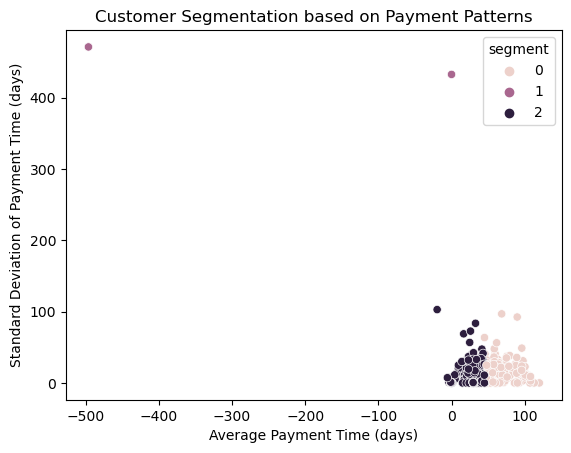

In [23]:
# Customer Segmentation
sns.scatterplot(data=customer_payment_stats, x='avg_payment_time', y='std_payment_time', hue='segment')
plt.title('Customer Segmentation based on Payment Patterns')
plt.xlabel('Average Payment Time (days)')
plt.ylabel('Standard Deviation of Payment Time (days)')
plt.show()

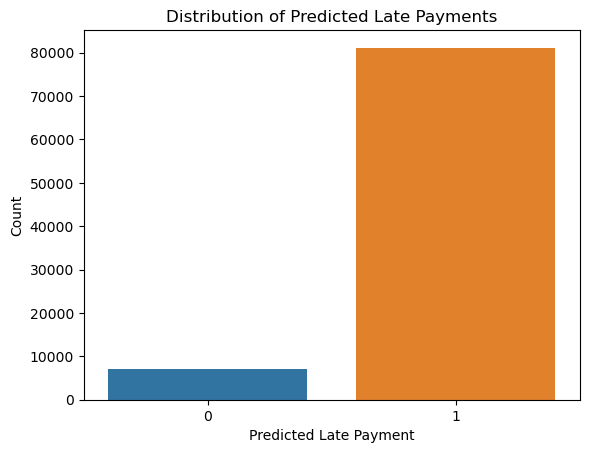

In [24]:
# Distribution of Predicted Late Payments
sns.countplot(x='Predicted_Late_Payment', data=open_invoices_data)
plt.title('Distribution of Predicted Late Payments')
plt.xlabel('Predicted Late Payment')
plt.ylabel('Count')
plt.show()

### List of all customer that has more that 80% chances of Late Payment

In [25]:
# Identifying customers for precautionary measures
high_risk_customers = customer_probability[customer_probability > 0.8].index
print("Number of Customers at High Risk of Late Payments: ", len(high_risk_customers))
for i in high_risk_customers:
    print(i)

Number of Customers at High Risk of Late Payments:  562
 Corp
6TH  Corp
A3 D Corp
AALA Corp
ABC  Corp
ABU  Corp
ABWA Corp
ACQU Corp
ACTO Corp
ADAM Corp
ADEL Corp
AFAQ Corp
AHAD Corp
AHIA Corp
AHLA Corp
AHME Corp
AIN  Corp
AISH Corp
AJIA Corp
AJMA Corp
AL D Corp
AL E Corp
AL F Corp
AL G Corp
AL H Corp
AL J Corp
AL K Corp
AL N Corp
AL O Corp
AL P Corp
AL T Corp
AL W Corp
AL Y Corp
AL Z Corp
AL-B Corp
ALAM Corp
ALBU Corp
ALDA Corp
ALEZ Corp
ALFA Corp
ALGH Corp
ALIC Corp
ALL  Corp
ALLI Corp
ALMA Corp
ALNE Corp
ALRA Corp
ALRY Corp
ALSH Corp
AMAT Corp
AMER Corp
AMI  Corp
AMOU Corp
ANFA Corp
ANSA Corp
ANTH Corp
ANTO Corp
AP L Corp
APA  Corp
APOT Corp
AQUI Corp
ARCO Corp
ARMA Corp
ASHA Corp
ASHJ Corp
ASHR Corp
ASIA Corp
ASSI Corp
ASWA Corp
AT K Corp
ATEL Corp
ATLA Corp
AVEN Corp
AXEL Corp
AYAN Corp
AZHA Corp
B8TA Corp
BACC Corp
BAHA Corp
BAHR Corp
BAM  Corp
BAND Corp
BARC Corp
BASE Corp
BASM Corp
BAWA Corp
BAZL Corp
BEAU Corp
BECC Corp
BEHB Corp
BENE Corp
BENM Corp
BERL Corp
BERN Corp
BEST Cor